### Bonus Task  Not completed 
- LSTM implementation for anomaly detction


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

import tensorflow as tf
from keras.models import Model, load_model, Sequential 
from keras.layers import Input, Dense, Dropout,LSTM, Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers



from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [52]:
SEED = 123 
DATA_SPLIT_PCT = 0.2

LABELS = ["Normal","Attack"]

# please adjust the dataset paths
NORMAL = "./data/BATADAL_dataset03.csv"
MIXED = "./data/BATADAL_dataset04.csv"

df_normal =  pd.read_csv(NORMAL, skipinitialspace=True)
df_mixed = pd.read_csv(MIXED, skipinitialspace=True)
df_mixed.ATT_FLAG.replace([-999, 1], [0, 1], inplace=True)
df_normal = df_normal.drop(['DATETIME'], axis=1)
df_mixed = df_mixed.drop(['DATETIME'], axis=1)

df = pd.concat([df_normal, df_mixed], ignore_index=True)

print(df.head())
print(df_mixed.shape)
print(df_normal.shape)
print(df.shape)

       L_T1      L_T2      L_T3      L_T4      L_T5      L_T6      L_T7  \
0  0.509730  2.049003  3.191145  2.792634  2.656091  5.316831  1.562321   
1  0.412580  2.009072  3.642565  2.831673  3.126387  5.494855  1.852043   
2  0.320112  1.986093  4.140192  3.256733  3.574601  5.500000  2.246126   
3  0.332879  2.009203  4.673478  3.744497  3.952379  5.500000  3.203573   
4  0.483496  2.089049  5.237937  4.409456  3.504676  5.500000  4.439714   

       F_PU1  S_PU1      F_PU2  ...     P_J256     P_J289     P_J415  \
0  98.998444    1.0  99.018150  ...  87.605774  26.495605  84.206619   
1  99.095901    1.0  99.115639  ...  89.448341  26.487326  85.900085   
2  98.420959    1.0  98.440498  ...  91.056114  26.487364  86.582474   
3  97.575172    1.0  97.594460  ...  92.594353  26.575815  88.020546   
4  97.351059    1.0  97.370277  ...  94.473099  26.723457  90.422462   

      P_J302     P_J306     P_J307     P_J317      P_J14     P_J422  ATT_FLAG  
0  18.901676  81.983734  18.791777  

In [26]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(values)
print(scaled_df.shape)

(12938, 44)


In [54]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)


df_train_0 = df_train.loc[df['ATT_FLAG'] == 0]
df_train_1 = df_train.loc[df['ATT_FLAG'] == 1]
df_train_test = df_train_0['ATT_FLAG']
df_train_0_x = df_train_0.drop(['ATT_FLAG'], axis=1)
df_train_1_x = df_train_1.drop(['ATT_FLAG'], axis=1)


df_valid_0 = df_valid.loc[df['ATT_FLAG'] == 0]
df_valid_1 = df_valid.loc[df['ATT_FLAG'] == 1]

df_valid_0_x = df_valid_0.drop(['ATT_FLAG'], axis=1)
df_valid_1_x = df_valid_1.drop(['ATT_FLAG'], axis=1)
df_valid_test = df_valid_0['ATT_FLAG']


df_test_0 = df_test.loc[df['ATT_FLAG'] == 0]
df_test_1 = df_test.loc[df['ATT_FLAG'] == 1]

df_test_0_x = df_test_0.drop(['ATT_FLAG'], axis=1)
df_test_1_x = df_test_1.drop(['ATT_FLAG'], axis=1)


print(df_train.shape)


(8280, 44)


In [28]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['ATT_FLAG'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['ATT_FLAG'], axis = 1))
df_test_x_rescaled.shape


(2588, 43)

In [41]:

x_train =df_train_0_x_rescaled.reshape(( df_train_0_x_rescaled.shape[0],1,df_train_0_x_rescaled.shape[1]))



y_train = df_valid_0_x_rescaled.reshape(( df_valid_0_x_rescaled.shape[0],1,df_valid_0_x_rescaled.shape[1]))



print(x_train.shape)

(8143, 1, 43)


-train data shape(batch_size,timesteps,dim)

In [46]:
model = Sequential()
model.add(LSTM(50, input_shape= (1,x_train.shape[2]),activation='relu', return_sequences= True))
model.add(LSTM(50))


model.add(Dense(1, activation= 'softmax'))


model.compile(loss='mse', optimizer ='adam', metrics= ['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 50)             18800     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 39,051
Trainable params: 39,051
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
history =  model.fit(x_train, df_train_test, epochs =70 , batch_size = 128, validation_data = (y_train, df_valid_test), verbose =2, shuffle= True)

Train on 8143 samples, validate on 2030 samples
Epoch 1/70
 - 2s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 2/70
 - 0s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 3/70
 - 0s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 4/70
 - 0s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 5/70
 - 0s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 6/70
 - 0s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 7/70
 - 0s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 8/70
 - 0s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 9/70
 - 0s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 10/70
 - 0s - loss: 1.0000 - acc: 0.0000e+00 - val_loss: 1.0000 - val_acc: 0.0000e+00
Epoch 11/70
 - 0s - loss: 1.0000 - acc: 0

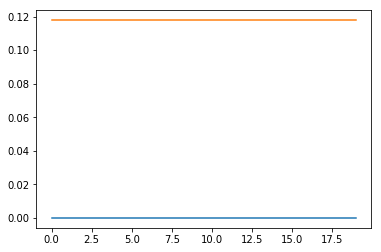

In [63]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [51]:
pred = model.predict(test_new )
mse = np.mean(np.power(test_new - pred, 2), axis=1)

print(mse)

[[1.49114364e+00 1.07358920e-01 6.19574012e+00 ... 6.11162100e+00
  5.53404197e+00 7.07867190e+00]
 [1.07999476e+00 2.41002538e-02 6.12288254e+00 ... 6.11162100e+00
  5.53404197e+00 6.33098442e+00]
 [4.45113181e-01 5.57955534e-01 3.23725221e+00 ... 6.11162100e+00
  5.53404197e+00 5.62501849e+00]
 ...
 [2.75336890e+00 1.84712578e+00 8.07359660e+00 ... 3.00079274e-01
  3.35420395e-04 2.67227014e-01]
 [3.92745111e+00 2.31746918e+00 5.21494713e+00 ... 3.00079274e-01
  3.35420395e-04 4.37413793e-01]
 [5.42440738e+00 3.21979794e+00 2.87806921e+00 ... 3.00079274e-01
  9.68108653e-03 7.07867190e+00]]
